
### url for challenge : https://www.hackerearth.com/challenges/competitive/garden-nerd-data-science-competition/

In [0]:
# !wget https://he-public-data.s3-ap-southeast-1.amazonaws.com/HE_Challenge_data.zip

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !unzip HE_Challenge_data

In [103]:
# unzip weights
!unzip drive/My\ Drive/flower102-weights

Archive:  drive/My Drive/flower102-weights.zip
   creating: flower102-weights/
  inflating: flower102-weights/resnext.h5  
  inflating: flower102-weights/efficient_net_weights.h5  
  inflating: flower102-weights/vgg.h5  
  inflating: flower102-weights/xception_net_weights.h5  
  inflating: flower102-weights/efficient_netb0_weights.h5  


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


## Data Pipeline

In [0]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [8]:
train.tail(3)

,image_id,category
18537,18537,78
18538,18538,74
18539,18539,29


In [9]:
test.head(3)

,image_id,category
0,18540,NaN
1,18541,NaN
2,18542,NaN


In [10]:
sample.head(3)

,image_id,category
0,18540,0
1,18541,0
2,18542,0


In [0]:
train = train.values

In [0]:
folders, num_samples = np.unique(train[:, 1], return_counts=True)

In [0]:
# make subdirectory of each class
for folder in folders:
  p = os.path.join('data/train', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)

In [0]:
for i in range(train.shape[0]):
  dest = os.path.join('data/train/', str(train[i][1]))
  src = os.path.join('data/train', str(train[i][0]) + '.jpg')
  shutil.move(src, dest)

#### validation - training split

In [0]:
SPLIT = 0.95 # 95% for training 5% for validation

In [0]:
# create the validation directory
if not os.path.isdir('data/val'):
  os.mkdir('data/val')


In [0]:
# creating subdirectories (of each category) in validation directory
for folder in folders:
  p = os.path.join('data/val', str(folder))
  if not os.path.isdir(p):
    os.mkdir(p)


In [0]:
# move the 3% data from training directory to validation directory
for f in folders:
  path = 'data/train/'+str(f)
  imgs = os.listdir(path)
  split_size = int(SPLIT*len(imgs))
  file_to_move = imgs[split_size:]
  
  for img_f in file_to_move:
    src = os.path.join(path, img_f)
    dest = os.path.join('data/val/'+str(f), img_f)
    shutil.move(src, dest)


###Data Augmentation


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 60,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
val_img_gen = ImageDataGenerator(
    rescale = 1/255.0,
)

In [22]:
train_gen = train_img_gen.flow_from_directory(
    'data/train',
    batch_size = 8,
    

)
val_gen = val_img_gen.flow_from_directory(
    'data/val/',
)

Found 17562 images belonging to 102 classes.
Found 978 images belonging to 102 classes.


In [23]:
for (x, y) in train_gen:
  print(x.shape, y.shape)
  break

(8, 256, 256, 3) (8, 102)


In [0]:
# train_gen.class_indices

In [0]:
# val_gen.class_indices

# Claasifiers Models


In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
adam = Adam(lr=0.00003)

####  Callback and Checkpoints


In [0]:
from keras.callbacks import Callback,  EarlyStopping

In [0]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)

# models checkpoints-- saves best only 
cp_efficient = keras.callbacks.ModelCheckpoint('efficient_net_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)
cp_xception = keras.callbacks.ModelCheckpoint('xception_net_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)
cp_vgg = keras.callbacks.ModelCheckpoint('vgg.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)
cp_resnet = keras.callbacks.ModelCheckpoint('resnet.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)
cp_nas = keras.callbacks.ModelCheckpoint('nas_net.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)

## Models Architecture

### 1. EfficientNet

In [0]:
# ! pip install keras_efficientnets
from keras_efficientnets import EfficientNetB5

In [0]:
efficient = EfficientNetB5((256, 256, 3), classes=102, include_top=False, weights='imagenet')

In [0]:
# efficient.summary()

In [0]:
### adding layers for flower classification

eff_avg = GlobalAveragePooling2D()(efficient.output)
eff_fc_1 = Dense(256, activation='relu')(eff_avg)
eff_fc_2 = Dense(128, activation='relu')(eff_fc_1)
eff_d = Dropout(0.25)(eff_fc_2)
eff_fc_3 = Dense(102, activation='softmax')(eff_d)


In [0]:
efficient = Model(efficient.input, outputs  = eff_fc_3)

In [0]:
# efficient.summary()

#### compilation and training

In [0]:
efficient.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# load the weights
efficient.load_weights('flower102-weights/efficient_net_weights.h5')

In [0]:
efficient_hist = efficient.fit_generator(train_gen, steps_per_epoch=18305//16, validation_data=val_gen, validation_steps=235//16, epochs=20, callbacks=[es, cp_efficient])

Epoch 1/20
1144/1144 [==============================] - 1027s 897ms/step - loss: 1.5999 - acc: 0.6207 - val_loss: 0.9304 - val_acc: 0.8054
Epoch 2/20
1144/1144 [==============================] - 953s 833ms/step - loss: 0.6006 - acc: 0.8462 - val_loss: 0.4831 - val_acc: 0.8665
Epoch 3/20
1144/1144 [==============================] - 954s 834ms/step - loss: 0.4193 - acc: 0.8930 - val_loss: 0.4611 - val_acc: 0.9261
Epoch 4/20
1144/1144 [==============================] - 954s 834ms/step - loss: 0.3970 - acc: 0.8987 - val_loss: 0.4217 - val_acc: 0.8941
Epoch 5/20
1144/1144 [==============================] - 954s 834ms/step - loss: 0.3019 - acc: 0.9223 - val_loss: 0.2996 - val_acc: 0.9433
Epoch 6/20
1144/1144 [==============================] - 953s 833ms/step - loss: 0.3006 - acc: 0.9272 - val_loss: 0.2225 - val_acc: 0.9438
Epoch 7/20
1144/1144 [==============================] - 953s 833ms/step - loss: 0.2877 - acc: 0.9277 - val_loss: 0.1657 - val_acc: 0.9458
Epoch 8/20
1144/1144 [===========

In [0]:
def plot_loss_accuracy():
  # plot loss
  print("training_loss =", hist.history['loss'][-1],  "   val_loss =", hist.history['val_loss'][-1])
  print("training_acc =", hist.history['acc'][-1]*100, "   val_acc =", hist.history['val_acc'][-1]*100)
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='training_loss')

  # plot accuracy
  plt.plot(hist.history['val_acc'], label='val_acc')
  plt.plot(hist.history['acc'], label='training_acc')
  plt.legend()
  plt.show()

training_loss = 0.19134688666930103    val_loss = 0.4899317234401574
training_acc = 94.9321873081431    val_acc = 91.53976312345257


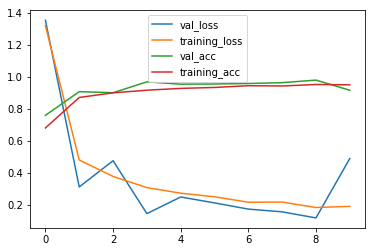

In [0]:
plot_loss_accuracy()

In [0]:
preserved_model = model

### 2.VGG19 


In [0]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

In [0]:
# vgg.summary()

In [0]:
### adding layers for flower classification
vgg_avg = GlobalAveragePooling2D()(vgg.output)
vgg_fc_1 = Dense(256, activation='relu')(vgg_avg)
vgg_fc_2 = Dense(128, activation='relu')(vgg_fc_1)
vgg_d = Dropout(0.25)(vgg_fc_2)
vgg_fc_3 = Dense(102, activation='softmax')(vgg_d)

In [0]:
vgg = Model(vgg.input, outputs  = vgg_fc_3)

In [0]:
# vgg.summary()

In [0]:
vgg.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# load the weights
vgg.load_weights('flower102-weights/vgg.h5')

In [0]:
vgg_hist = vgg.fit_generator(train_gen, steps_per_epoch=18305//16, validation_data=val_gen, validation_steps=235//16, epochs=20, callbacks=[es, cp_vgg])

W0819 13:57:12.817914 139621115123584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
1144/1144 [==============================] - 772s 675ms/step - loss: 4.1744 - acc: 0.0978 - val_loss: 3.2947 - val_acc: 0.2881
Epoch 2/20
1144/1144 [==============================] - 757s 661ms/step - loss: 2.3881 - acc: 0.4337 - val_loss: 1.4322 - val_acc: 0.6626
Epoch 3/20
1144/1144 [==============================] - 756s 661ms/step - loss: 1.4062 - acc: 0.6495 - val_loss: 1.0895 - val_acc: 0.7241
Epoch 4/20
1144/1144 [==============================] - 756s 661ms/step - loss: 0.9432 - acc: 0.7561 - val_loss: 0.5591 - val_acc: 0.8276
Epoch 5/20
1144/1144 [==============================] - 757s 661ms/step - loss: 0.7069 - acc: 0.8145 - val_loss: 0.5660 - val_acc: 0.8548
Epoch 6/20
1144/1144 [==============================] - 757s 661ms/step - loss: 0.5448 - acc: 0.8559 - val_loss: 0.3157 - val_acc: 0.9138
Epoch 7/20
1144/1144 [==============================] - 756s 661ms/step - loss: 0.4480 - acc: 0.8804 - val_loss: 0.3707 - val_acc: 0.9089
Epoch 8/20
1144/1144 [============

### 3. XceptionNet

In [0]:
from keras.applications.xception import Xception

In [0]:
xception = Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

In [0]:
# xception.summary()

In [0]:
xc_avg = GlobalAveragePooling2D()(xception.output)
xc_fc_1 = Dense(256, activation='relu')(xc_avg)
xc_fc_2 = Dense(128, activation='relu')(xc_fc_1)
xc_d = Dropout(0.25)(xc_fc_2)
xc_fc_3 = Dense(102, activation='softmax')(xc_d)

In [0]:
xception = Model(xception.input, outputs  = xc_fc_3)

In [0]:
xception.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# load the weights
xception.load_weights('flower102-weights/xception_net_weights.h5')

In [0]:
xception_hist = xception.fit_generator(train_gen, steps_per_epoch=18305//16, validation_data=val_gen, validation_steps=235//16, epochs=20, callbacks=[es, cp_xception])

Epoch 1/20
1144/1144 [==============================] - 1048s 916ms/step - loss: 1.9454 - acc: 0.5909 - val_loss: 0.4648 - val_acc: 0.8876
Epoch 2/20
1144/1144 [==============================] - 1033s 903ms/step - loss: 0.5133 - acc: 0.8881 - val_loss: 0.1565 - val_acc: 0.9631
Epoch 3/20
1144/1144 [==============================] - 1038s 907ms/step - loss: 0.2517 - acc: 0.9473 - val_loss: 0.0823 - val_acc: 0.9655
Epoch 4/20
1144/1144 [==============================] - 1035s 904ms/step - loss: 0.1482 - acc: 0.9679 - val_loss: 0.0345 - val_acc: 0.9926
Epoch 5/20
1144/1144 [==============================] - 1035s 905ms/step - loss: 0.1082 - acc: 0.9755 - val_loss: 0.0330 - val_acc: 0.9906
Epoch 6/20
1144/1144 [==============================] - 1034s 904ms/step - loss: 0.0731 - acc: 0.9845 - val_loss: 0.0333 - val_acc: 0.9901


### 4. EfficientNetB0 

In [0]:
from keras_efficientnets import EfficientNetB0

In [0]:
efficientb0 = EfficientNetB0((256, 256, 3), classes=102, include_top=False, weights='imagenet')

In [0]:
# efficientb0.summary()

In [0]:
effb0_avg = GlobalAveragePooling2D()(efficientb0.output)
effb0_fc_1 = Dense(256, activation='relu')(effb0_avg)
effb0_fc_2 = Dense(128, activation='relu')(effb0_fc_1)
effb0_d = Dropout(0.25)(effb0_fc_2)
effb0_fc_3 = Dense(102, activation='softmax')(effb0_d)

In [0]:
efficientb0 = Model(efficientb0.input, outputs  = effb0_fc_3)

In [0]:
# efficientb0.summary()

In [0]:
cp_efficientb0 = keras.callbacks.ModelCheckpoint('efficient_netb0_weights.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)


In [0]:
efficientb0.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# load the weights
efficientb0.load_weights('flower102-weights/efficient_netb0_weights.h5')

In [0]:
efficientb0_hist = efficientb0.fit_generator(train_gen, steps_per_epoch=18305//16, validation_data=val_gen, validation_steps=235/16, epochs=20, callbacks=[es, cp_efficientb0])

### 5. Resnext

In [0]:
import keras
from keras_applications.resnext import ResNeXt50

resnext = ResNeXt50(weights='imagenet', input_shape = (256, 256, 3), classes=102, include_top=False, backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils)

In [0]:
# resnext.summary()

In [0]:
res_avg = GlobalAveragePooling2D()(resnext.output)
res_fc_1 = Dense(256, activation='relu')(res_avg)
res_fc_2 = Dense(128, activation='relu')(res_fc_1)
res_d = Dropout(0.25)(res_fc_2)
res_fc_3 = Dense(102, activation='softmax')(res_d)

In [0]:
resnext = Model(resnext.input, outputs  = res_fc_3)

In [0]:
# resnext.summary()


In [0]:
resnext.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
resnext.load_weights('flower102-weights/resnext.h5')

In [0]:
cp_resnext = keras.callbacks.ModelCheckpoint('resnext.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)

In [37]:
resnext_hist = resnext.fit_generator(train_gen, steps_per_epoch=17562//8, validation_data=val_gen, validation_steps=978//8, epochs=20, callbacks=[es, cp_resnext])


W0821 10:38:12.671050 139885793322880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
2195/2195 [==============================] - 2776s 1s/step - loss: 1.7563 - acc: 0.6372 - val_loss: 0.0873 - val_acc: 0.9788
Epoch 2/20
2195/2195 [==============================] - 2760s 1s/step - loss: 0.2927 - acc: 0.9380 - val_loss: 0.0230 - val_acc: 0.9906
Epoch 3/20
2195/2195 [==============================] - 2758s 1s/step - loss: 0.1572 - acc: 0.9642 - val_loss: 0.0384 - val_acc: 0.9917
Epoch 4/20
2195/2195 [==============================] - 2755s 1s/step - loss: 0.1110 - acc: 0.9752 - val_loss: 0.0066 - val_acc: 0.9990
Epoch 5/20
2195/2195 [==============================] - 2757s 1s/step - loss: 0.0938 - acc: 0.9786 - val_loss: 0.0198 - val_acc: 0.9956


#### Archive the model weights and evaluate on val data(to check whether weights are loaded properly or not) -- preventive measure

In [0]:
efficient_archive = efficient
efficientb0_archive = efficientb0
vgg_archive = vgg
xception_archive = xception
resenext_archive = resnext

In [238]:
efficient.evaluate_generator(val_gen, steps=978//8)

[0.09671708277134472, 0.9799896050205845]

In [239]:
efficientb0.evaluate_generator(val_gen, steps=978//8)

[0.014953158555742113, 1.0]

In [240]:
vgg.evaluate_generator(val_gen, steps=978//8)

[0.04328215931932609, 0.9838877338877339]

In [241]:
xception.evaluate_generator(val_gen, steps=978//8)

[0.01216567932496069, 0.9955821203342842]

In [0]:
resnext.evaluate_generator(val_gen, steps=978//8)

## Time to make prediction

In [0]:
shutil.rmtree.

In [0]:
if not os.path.isdir('data/test/test_data'):
  os.mkdir('data/test/test_data')

In [0]:
# make subdirectory of each class
for each in os.listdir('data/test/'):
  dest = 'data/test/test_data'
  src = os.path.join('data/test', each)
  shutil.move(src, dest)



In [80]:
len(os.listdir('data/test/test_data/'))

2010

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [219]:
test_generator = test_datagen.flow_from_directory(
        'data/test',
        shuffle = False,
        class_mode='categorical',
        batch_size=1
)

Found 2009 images belonging to 1 classes.


In [0]:
train_dict = train_gen.class_indices

In [0]:
new_dict = dict([(value, key) for key, value in train_dict.items()])

In [0]:
filenames = test_generator.filenames

In [0]:
nb_samples = len(filenames)

In [0]:
models = [resnext, efficientb0, efficient, xception, vgg]

In [0]:
def prediction_n_decode(model):
  predictions = model.predict_generator(test_generator,steps = nb_samples)
  predictions = np.argmax(predictions, axis=1)
  actual_predictions = [int(new_dict[each]) for each in predictions]
  return actual_predictions

In [0]:
p1 = vgg.predict_generator(test_generator,steps = nb_samples)
p1 = np.argmax(p1, axis=1)
actual_p1 = [int(new_dict[each]) for each in p1]

In [237]:
actual_p1[-5:]

[19, 57, 74, 76, 37]

In [226]:
resnext_pred[-5:]

[67, 51, 72, 89, 63]

In [0]:
pred_of_all_models = []

In [0]:
pred_arr = np.array(predictions)

In [207]:
pred_arr.shape

(5, 2009)

In [209]:
pred_arr[:, -5:]

array([[67, 51, 72, 89, 63],
       [10, 42, 89, 85, 76],
       [19, 57, 74, 76, 37],
       [93, 52, 21, 95, 89],
       [80, 80, 65, 70, 17]])

In [93]:
sample.head(4)

,image_id,category
0,18540,74
1,18541,3
2,18542,76
3,18543,12


In [0]:
sample.category = actual_predictions

In [227]:
actual_predictions[-5:]

[58, 51, 97, 72, 51]

In [95]:
sample.tail(10)

,image_id,category
1999,20539,77
2000,20540,3
2001,20541,77
2002,20542,81
2003,20543,77
2004,20544,58
2005,20545,51
2006,20546,97
2007,20547,72
2008,20548,51


In [96]:
type(sample)

pandas.core.frame.DataFrame

In [0]:
sample.to_csv('submission.csv', index=False)